# 第5章 决策树

1．分类决策树模型是表示基于特征对实例进行分类的树形结构。决策树可以转换成一个**if-then**规则的集合，也可以看作是定义在特征空间划分上的类的条件概率分布。

2．决策树学习旨在构建一个与训练数据拟合很好，并且复杂度小的决策树。因为从可能的决策树中直接选取最优决策树是NP完全问题。现实中采用启发式方法学习次优的决策树。

决策树学习算法包括3部分：特征选择、树的生成和树的剪枝。常用的算法有ID3、
C4.5和CART。

3．特征选择的目的在于选取对训练数据能够分类的特征。特征选择的关键是其准则。常用的准则如下：

（1）样本集合$D$对特征$A$的信息增益（ID3）


$$g(D, A)=H(D)-H(D|A)$$

$$H(D)=-\sum_{k=1}^{K} \frac{\left|C_{k}\right|}{|D|} \log _{2} \frac{\left|C_{k}\right|}{|D|}$$

$$H(D | A)=\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} H\left(D_{i}\right)$$

其中，$H(D)$是**不附加任何特征**数据集$D$的熵，$H(D_i)$是**划分数据集后得到$n$个数据集中**数据集$D_i$的熵，$H(D|A)$是数据集$D$对特征$A$的条件熵。	$D_i$是$D$中特征$A$取第$i$个值的样本子集，$C_k$是$D$中属于第$k$类的样本子集。$n$是特征$A$取 值的个数，$K$是类的个数。

（2）样本集合$D$对特征$A$的信息增益比（C4.5）


$$g_{R}(D, A)=\frac{g(D, A)}{H(D)}$$


其中，$g(D,A)$是信息增益，$H(D)$是数据集$D$的熵。消除特征取值个数带来的影响。

（3）样本集合$D$的基尼指数（CART）

$$\operatorname{Gini}(D)=1-\sum_{k=1}^{K}\left(\frac{\left|C_{k}\right|}{|D|}\right)^{2}$$

特征$A$条件下集合$D$的基尼指数：

 $$\operatorname{Gini}(D, A)=\frac{\left|D_{1}\right|}{|D|} \operatorname{Gini}\left(D_{1}\right)+\frac{\left|D_{2}\right|}{|D|} \operatorname{Gini}\left(D_{2}\right)$$
 
4．决策树的生成。通常使用**信息增益最大、信息增益比最大或基尼指数最小**作为特征选择的准则。决策树的生成往往通过计算信息增益或其他指标，从根结点开始，递归地产生决策树。这相当于用信息增益或其他准则不断地选取局部最优的特征，或将训练集分割为能够基本正确分类的子集。

5．决策树的剪枝。由于生成的决策树存在过拟合问题，需要对它进行剪枝，以简化学到的决策树。决策树的剪枝，往往从已生成的树上剪掉一些叶结点或叶结点以上的子树，并将其父结点或根结点作为新的叶结点，从而简化生成的决策树。


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter
import math
from math import log
import pprint

### 书上题目5.1

In [2]:
# 书上题目5.1
def create_data():
    datasets = [['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
    # 返回数据集和每个维度的名称
    return datasets, labels

In [3]:
datasets, labels = create_data()

In [4]:
train_data = pd.DataFrame(datasets, columns=labels)

In [5]:
train_data

,年龄,有工作,有自己的房子,信贷情况,类别
0,青年,否,否,一般,否
1,青年,否,否,好,否
2,青年,是,否,好,是
3,青年,是,是,一般,是
4,青年,否,否,一般,否
5,中年,否,否,一般,否
6,中年,否,否,好,否
7,中年,是,是,好,是
8,中年,否,是,非常好,是
9,中年,否,是,非常好,是


In [6]:
# 熵
def calc_ent(datasets):
    data_length = len(datasets)
    label_count = {}
    for i in range(data_length):
        label = datasets[i][-1]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    ent = -sum([(p / data_length) * log(p / data_length, 2)
                for p in label_count.values()])
    return ent
# def entropy(y):
#     """
#     Entropy of a label sequence
#     """
#     hist = np.bincount(y)
#     ps = hist / np.sum(hist)
#     return -np.sum([p * np.log2(p) for p in ps if p > 0])


# 经验条件熵
def cond_ent(datasets, axis=0):
    data_length = len(datasets)
    feature_sets = {}
    for i in range(data_length):
        feature = datasets[i][axis]
        if feature not in feature_sets:
            feature_sets[feature] = []
        feature_sets[feature].append(datasets[i])
    cond_ent = sum(
        [(len(p) / data_length) * calc_ent(p) for p in feature_sets.values()])
    return cond_ent


# 信息增益
def info_gain(ent, cond_ent):
    return ent - cond_ent


def info_gain_train(datasets):
    count = len(datasets[0]) - 1
    ent = calc_ent(datasets)
#     ent = entropy(datasets)
    best_feature = []
    for c in range(count):
        c_info_gain = info_gain(ent, cond_ent(datasets, axis=c))
        best_feature.append((c, c_info_gain))
        print('特征({}) - info_gain - {:.3f}'.format(labels[c], c_info_gain))
    # 比较大小
    best_ = max(best_feature, key=lambda x: x[-1])
    return '特征({})的信息增益最大，选择为根节点特征'.format(labels[best_[0]])

In [7]:
info_gain_train(np.array(datasets))

特征(年龄) - info_gain - 0.083
特征(有工作) - info_gain - 0.324
特征(有自己的房子) - info_gain - 0.420
特征(信贷情况) - info_gain - 0.363


'特征(有自己的房子)的信息增益最大，选择为根节点特征'

---

利用ID3算法生成决策树，例5.3

In [8]:
# 定义节点类 二叉树
class Node:
    def __init__(self, root=True, label=None, feature_name=None, feature=None):
        self.root = root
        self.label = label
        self.feature_name = feature_name
        self.feature = feature
        self.tree = {}
        self.result = {
            'label:': self.label,
            'feature': self.feature,
            'tree': self.tree
        }

    def __repr__(self):
        return '{}'.format(self.result)

    def add_node(self, val, node):
        self.tree[val] = node

    def predict(self, features):
        if self.root is True:
            return self.label
        return self.tree[features[self.feature]].predict(features)


class DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}

    # 熵
    @staticmethod
    def calc_ent(datasets):
        data_length = len(datasets)
        label_count = {}
        for i in range(data_length):
            label = datasets[i][-1]
            if label not in label_count:
                label_count[label] = 0
            label_count[label] += 1
        ent = -sum([(p / data_length) * log(p / data_length, 2)
                    for p in label_count.values()])
        return ent

    # 经验条件熵
    def cond_ent(self, datasets, axis=0):
        data_length = len(datasets)
        feature_sets = {}
        for i in range(data_length):
            feature = datasets[i][axis]
            if feature not in feature_sets:
                feature_sets[feature] = []
            feature_sets[feature].append(datasets[i])
        cond_ent = sum([(len(p) / data_length) * self.calc_ent(p)
                        for p in feature_sets.values()])
        return cond_ent

    # 信息增益
    @staticmethod
    def info_gain(ent, cond_ent):
        return ent - cond_ent

    def info_gain_train(self, datasets):
        count = len(datasets[0]) - 1
        ent = self.calc_ent(datasets)
        best_feature = []
        for c in range(count):
            c_info_gain = self.info_gain(ent, self.cond_ent(datasets, axis=c))
            best_feature.append((c, c_info_gain))
        # 比较大小
        best_ = max(best_feature, key=lambda x: x[-1])
        return best_

    def train(self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        _, y_train, features = train_data.iloc[:, :
                                               -1], train_data.iloc[:,
                                                                    -1], train_data.columns[:
                                                                                            -1]
        # 1,若D中实例属于同一类Ck，则T为单节点树，并将类Ck作为结点的类标记，返回T
        if len(y_train.value_counts()) == 1:
            return Node(root=True, label=y_train.iloc[0])

        # 2, 若A为空，则T为单节点树，将D中实例树最大的类Ck作为该节点的类标记，返回T
        if len(features) == 0:
            return Node(
                root=True,
                label=y_train.value_counts().sort_values(
                    ascending=False).index[0])

        # 3,计算最大信息增益 同5.1,Ag为信息增益最大的特征
        max_feature, max_info_gain = self.info_gain_train(np.array(train_data))
        max_feature_name = features[max_feature]

        # 4,Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是实例数最大的类Ck作为该节点的类标记，返回T
        if max_info_gain < self.epsilon:
            return Node(
                root=True,
                label=y_train.value_counts().sort_values(
                    ascending=False).index[0])

        # 5,构建Ag子集
        node_tree = Node(
            root=False, feature_name=max_feature_name, feature=max_feature)

        feature_list = train_data[max_feature_name].value_counts().index
        for f in feature_list:
            sub_train_df = train_data.loc[train_data[max_feature_name] ==
                                          f].drop([max_feature_name], axis=1)

            # 6, 递归生成树
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)

        # pprint.pprint(node_tree.tree)
        return node_tree

    def fit(self, train_data):
        self._tree = self.train(train_data)
        return self._tree

    def predict(self, X_test):
        return self._tree.predict(X_test)

In [9]:
datasets, labels = create_data()
data_df = pd.DataFrame(datasets, columns=labels)
dt = DTree()
tree = dt.fit(data_df)

In [10]:
tree

{'label:': None, 'feature': 2, 'tree': {'否': {'label:': None, 'feature': 1, 'tree': {'否': {'label:': '否', 'feature': None, 'tree': {}}, '是': {'label:': '是', 'feature': None, 'tree': {}}}}, '是': {'label:': '是', 'feature': None, 'tree': {}}}}

In [11]:
dt.predict(['老年', '否', '否', '一般'])

'否'

### scikit-learn实例

In [12]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = [
        'sepal length', 'sepal width', 'petal length', 'petal width', 'label'
    ]
    data = np.array(df.iloc[:100, [0, 1, -1]])
    # print(data)
    return data[:, :2], data[:, -1]


X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [14]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train,)

DecisionTreeClassifier()

In [15]:
clf.score(X_test, y_test)

0.9666666666666667

In [16]:
tree_pic = export_graphviz(clf, out_file="mytree.pdf")
with open('mytree.pdf') as f:
    dot_graph = f.read()

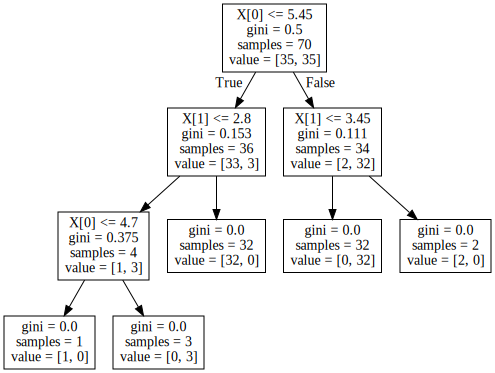

In [17]:
graphviz.Source(dot_graph)

## 第5章决策树-习题

### 习题5.1
根据表5.1所给的训练数据集，利用信息增益比（C4.5算法）生成决策树。

**解答：**  

表5.1 贷款申请样本数据表  

ID | 年龄 | 有工作 | 有自己的房子 | 信贷情况 | 类别
:-: | :-: | :-: | :-: | :-: | :-: 
1 | 青年 | 否 | 否 | 一般 | 否
2 | 青年 | 否 | 否 | 好 | 否
3 | 青年 | 是 | 否 | 好 | 是
4 | 青年 | 是 | 是 | 一般 | 是
5 | 青年 | 否 | 否 | 一般 | 否
6 | 中年 | 否 | 否 | 一般 | 否
7 | 中年 | 否 | 否 | 好 | 否
8 | 中年 | 是 | 是 | 好 | 是
9 | 中年 | 否 | 是 | 非常好 | 是
10 | 中年 | 否 | 是 | 非常好 | 是
11 | 老年 | 否 | 是 | 非常好 | 是
12 | 老年 | 否 | 是 | 好 | 是
13 | 老年 | 是 | 否 | 好 | 是
14 | 老年 | 是 | 否 | 非常好 | 是
15 | 老年 | 否 | 否 | 一般 | 否

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import numpy as np
import pandas as pd

from sklearn import tree
import graphviz

features = ["年龄", "有工作", "有自己的房子", "信贷情况"]
X_train = pd.DataFrame([
    ["青年", "否", "否", "一般"],
    ["青年", "否", "否", "好"],
    ["青年", "是", "否", "好"],
    ["青年", "是", "是", "一般"],
    ["青年", "否", "否", "一般"],
    ["中年", "否", "否", "一般"],
    ["中年", "否", "否", "好"],
    ["中年", "是", "是", "好"],
    ["中年", "否", "是", "非常好"],
    ["中年", "否", "是", "非常好"],
    ["老年", "否", "是", "非常好"],
    ["老年", "否", "是", "好"],
    ["老年", "是", "否", "好"],
    ["老年", "是", "否", "非常好"],
    ["老年", "否", "否", "一般"]
])
y_train = pd.DataFrame(["否", "否", "是", "是", "否", 
                        "否", "否", "是", "是", "是", 
                        "是", "是", "是", "是", "否"])
# 数据预处理
le_x = preprocessing.LabelEncoder()
le_x.fit(np.unique(X_train))
X_train = X_train.apply(le_x.transform)
le_y = preprocessing.LabelEncoder()
le_y.fit(np.unique(y_train))
y_train = y_train.apply(le_y.transform)
# 调用sklearn.DT建立训练模型
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

# 可视化
dot_data = tree.export_graphviz(model_tree, out_file=None,
                                    feature_names=features,
                                    class_names=[str(k) for k in np.unique(y_train)],
                                    filled=True, rounded=True,
                                    special_characters=True)
graph = graphviz.Source(dot_data)
graph

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

### 习题5.2
&emsp;&emsp;已知如表5.2所示的训练数据，试用平方误差损失准则生成一个二叉回归树。  
表5.2 训练数据表  

| $x_i$ | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |  
| - | - | - | - | - | - | - | - | - | - | - |  
| $y_i$ | 4.50 | 4.75 | 4.91 | 5.34 | 5.80 | 7.05 | 7.90 | 8.23 | 8.70 | 9.00

**解答：**  
&emsp;&emsp;决策树的生成就是递归地构建二叉决策树的过程，对回归树用平方误差最小化准则，对分类树用基尼指数（Gini index）最小化准则，进行特征选择，生成二叉树。  
> 算法5.5（最小二乘回归树生成算法）  
输入：训练数据集$D$  
输出：回归树$f(x)$  
在训练数据集所在的输入空间中，递归地将每个区域划分为两个子区域并决定每个子区域上的输出值，构建二叉决策树；  
(1)选择最优切分变量$j$与切分点$s$，求解$$\min_{j,s} \left[ \min_{c_1} \sum_{x_i \in R_1(j,s)} (y_i - c_1)^2 + \min_{c_2} \sum_{x_i \in R_2(j,s)} (y_i - c_2)^2\right]$$遍历变量$j$，对固定的切分变量$j$扫描切分点$s$，选择使得上式达到最小值的对$(j,s)$  
(2)用选定的对$(j,s)$划分区域并决定相应的输出值：$$R_1(j,s)=\{x|x^{(j)}\leqslant s\}, R_2(j,s)=\{x|x^{(j)} > s\} \\ 
\hat{c_m} = \frac{1}{N_m} \sum_{x_i \in R_m(j,s)} y_i, x \in R_m, m=1,2 $$
(3)继续对两个子区域调用步骤(1),(2)，直至满足停止条件  
(4)将输入空间划分为$M$个区域$R_1,R_2,\cdots,R_M$，生成决策树：$$f(x)=\sum_{m=1}^M \hat{c_m} I(x \in R_m)$$

In [19]:
import numpy as np


class LeastSqRTree:
    def __init__(self, train_X, y, epsilon):
        # 训练集特征值
        self.x = train_X
        # 类别
        self.y = y
        # 特征总数
        self.feature_count = train_X.shape[1]
        # 损失阈值
        self.epsilon = epsilon
        # 回归树
        self.tree = None

    def _fit(self, x, y, feature_count, epsilon):
        # 选择最优切分点变量j与切分点s
        (j, s, minval, c1, c2) = self._divide(x, y, feature_count)
        # 初始化树
        tree = {"feature": j, "value": x[s, j], "left": None, "right": None}
        if minval < self.epsilon or len(y[np.where(x[:, j] <= x[s, j])]) <= 1:
            tree["left"] = c1
        else:
            tree["left"] = self._fit(x[np.where(x[:, j] <= x[s, j])],
                                     y[np.where(x[:, j] <= x[s, j])],
                                     self.feature_count, self.epsilon)
        if minval < self.epsilon or len(y[np.where(x[:, j] > s)]) <= 1:
            tree["right"] = c2
        else:
            tree["right"] = self._fit(x[np.where(x[:, j] > x[s, j])],
                                      y[np.where(x[:, j] > x[s, j])],
                                      self.feature_count, self.epsilon)
        return tree

    def fit(self):
        self.tree = self._fit(self.x, self.y, self.feature_count, self.epsilon)

    @staticmethod
    def _divide(x, y, feature_count):
        # 初始化损失误差
        cost = np.zeros((feature_count, len(x)))
        # 公式5.21
        for i in range(feature_count):
            for k in range(len(x)):
                # k行i列的特征值
                value = x[k, i]
                y1 = y[np.where(x[:, i] <= value)]
                c1 = np.mean(y1)
                y2 = y[np.where(x[:, i] > value)]
                c2 = np.mean(y2)
                y1[:] = y1[:] - c1
                y2[:] = y2[:] - c2
                cost[i, k] = np.sum(y1 * y1) + np.sum(y2 * y2)
        # 选取最优损失误差点
        cost_index = np.where(cost == np.min(cost))
        # 选取第几个特征值
        j = cost_index[0][0]
        # 选取特征值的切分点
        s = cost_index[1][0]
        # 求两个区域的均值c1,c2
        c1 = np.mean(y[np.where(x[:, j] <= x[s, j])])
        c2 = np.mean(y[np.where(x[:, j] > x[s, j])])
        return j, s, cost[cost_index], c1, c2

In [20]:
train_X = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]).T
y = np.array([4.50, 4.75, 4.91, 5.34, 5.80, 7.05, 7.90, 8.23, 8.70, 9.00])

model_tree = LeastSqRTree(train_X, y, .2)
model_tree.fit()
model_tree.tree

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'feature': 0,
 'value': 5,
 'left': {'feature': 0, 'value': 3, 'left': 4.72, 'right': 5.57},
 'right': {'feature': 0,
  'value': 7,
  'left': {'feature': 0, 'value': 6, 'left': 7.05, 'right': 7.9},
  'right': {'feature': 0, 'value': 8, 'left': 8.23, 'right': 8.85}}}

根据上面程序的输出，可得到用平方误差损失准则生成一个二叉回归树：$$f(x)=\begin{cases}
4.72 & x \le 3\\
5.57 & 3 < x \le 5\\
7.05 & 5 < x \le 6\\
7.9 & 6 < x \le 7 \\
8.23 & 7 < x \le 8\\
8.85 & x > 8\\
\end{cases}$$

### 习题5.3

&emsp;&emsp;证明 CART 剪枝算法中，当$\alpha$确定时，存在唯一的最小子树$T_{\alpha}$使损失函数$C_{\alpha}(T)$最小。

**解答：**  
**第1步：**内部节点是否剪枝只与以该节点为根节点的子树有关。  
剪枝过程：  
计算子树的损失函数：$$C_{\alpha}(T)=C(T)+\alpha$$其中，$\displaystyle C(T) = \sum_{t=1}^{|T|}N_t (1 - \sum_{k=1}^K (\frac{N_{tk}}{N_t})^2)$，$|T|$是叶结点个数，$K$是类别个数。  
有剪枝前子树$T_0$，剪枝后子树$T_1$，满足$C_{\alpha}(T_1) \leqslant C_{\alpha}(T_0)$则进行剪枝。 

----

**第2步（反证法）：**假设当$\alpha$确定时，存在两颗子树$T_1,T_2$都使得损失函数$C_{\alpha}$最小。  
第1种情况：假设被剪枝的子树在同一边，易知其中一个子树会由另一个子树剪枝而得到，故不可能存在两个最优子树，原结论得证。  
第2种情况：假设被剪枝的子树不在同一边，易知被剪枝掉的子树都可以使损失函数$C_{\alpha}$最小，故两颗子树都可以继续剪枝，故不可能存在两个最优子树，原结论得证。

### 习题5.4

&emsp;&emsp;证明 CART 剪枝算法中求出的子树序列$\{T_0,T_1,\cdots,T_n\}$分别是区间$\alpha \in [\alpha_i,\alpha_{i+1})$的最优子树$T_{\alpha}$，这里$i=0,1,\cdots,n,0=\alpha_0 < \alpha_1 < \cdots, \alpha_n < +\infty$。

**解答：**  
原结论可以表述为：将$\alpha$从小增大，$0=\alpha_0<\alpha_1<\cdots<\alpha_n < +\infty$，在每个区间$[\alpha_i,\alpha_{i+1})$中，子树$T_i$是这个区间里最优的。  
**第1步：**易证，当$\alpha=0$时，整棵树$T_0$是最优的，当$\alpha \rightarrow +\infty$时，根结点组成的单结点树（即$T_n$）是最优的。

----

**第2步：**  
&emsp;&emsp;由于每次剪枝剪的都是某个内部结点的子结点，也就是将某个内部结点的所有子结点回退到这个内部结点里，并将这个内部结点作为叶子结点。因此在计算整体的损失函数时，这个内部结点以外的值都没变，只有这个内部结点的局部损失函数改变了，因此本来需要计算全局的损失函数，但现在只需要计算内部结点剪枝前和剪枝后的损失函数。  
从整体树$T_0$开始剪枝，对$T_0$的任意内部结点$t$    
剪枝前的状态：有$|T_t|$个叶子结点，预测误差是$C(T_t)$  
剪枝后的状态：只有本身一个叶子结点，预测误差是$C(t)$
因此剪枝前的以$t$结点为根结点的子树的损失函数是$$C_{\alpha}(T_t) = C(T_t) + \alpha|T_t|$$剪枝后的损失函数是$$C_{\alpha}(t) = C(t) + \alpha$$易得，一定存在一个$\alpha$使得$C_{\alpha}(T_t) = C_{\alpha}(t)$，这个值为$$\alpha=\frac{C(t)-C(T_t)}{|T_t|-1}$$可知，找到$\alpha$即找到了子结点$t$，即完成了剪枝，得到最优子树$T_1$  
根据书中第73页，采用以下公式计算剪枝后整体损失函数减少的程度：$$g(t)=\frac{C(t)-C(T_t)}{|T_t|-1}$$在$T_0$中剪去$g(t)$最小的$T_t$，将得到的子树作为$T_1$，同时将最小的$g(t)$设为$\alpha_1$，$T_1$为区间$[\alpha_1,\alpha_2)$的最优子树。  
依次类推，子树$T_i$是区间$[\alpha_i,\alpha_{i+1})$里最优的，原结论得证。

----

**参考文献：**  
1. MrTriste：https://blog.csdn.net/wjc1182511338/article/details/76793164
2. http://www.pianshen.com/article/1752163397/

----

**讨论：**为什么$\alpha$要取最小的$g(t)$呢？  
<br/><center>
<img style="border-radius: 0.3125em;box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);width: 354px;" src="../images/5-1-min-g(t).png"><br><div style="color:orange; border-bottom: 1px solid #d9d9d9;display: inline-block;color: #000;padding: 2px;">图5.1 最小的$g(t)$</div></center>  
&emsp;&emsp;以图中两个点为例，结点1和结点2，$g(t)_2$大于$g(t)_1$，假设在所有结点中$g(t)_1$最小，$g(t)_2$最大，两种选择方法：当选择最大值$g(t)_2$，即结点2进行剪枝，但此时结点1的剪枝前的误差大于剪枝后的误差，即如果不剪枝，误差变大，依次类推，对其它所有的结点的$g(t)$都是如此，从而造成整体的累计误差更大。反之，如果选择最小值$g(t)_1$，即结点1进行剪枝，则其余结点不剪的误差要小于剪枝后的误差，不剪枝为好，且整体的误差最小。从而以最小$g(t)$剪枝获得的子树是该$\alpha$值下的最优子树。

----
参考代码：https://github.com/wzyonggege/statistical-learning-method

本文代码更新地址：https://github.com/fengdu78/lihang-code

习题解答：https://github.com/datawhalechina/statistical-learning-method-solutions-manual

中文注释制作：机器学习初学者公众号：ID:ai-start-com

配置环境：python 3.5+

代码全部测试通过。
![gongzhong](../gongzhong.jpg)